**Library Imports and Initial Setup**

In [ ]:
#Import the necessary libraries and the Italian fasttext model
%%capture
!pip install fasttext
!pip install keras-tuner
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, TimeDistributed, Dense,  Dropout, Conv1D,GlobalMaxPooling1D,RepeatVector, Add, Input
from sklearn.metrics import precision_recall_curve, auc, f1_score, classification_report
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
import fasttext.util
import os
import tensorflow as tf
import pandas as pd
import warnings
import time
import matplotlib.pyplot as plt
import keras_tuner as kt
import numpy as np
warnings.filterwarnings('ignore')
fasttext.util.download_model('it', if_exists='ignore')

**Preprocessing - Data Extraction**

We will be using the files from the previous assignment from the Venice Italian Treebank. The 'SYM' and 'PART' tags will be ignored as the subsets do not include them.

In [ ]:
# Define a function to read CoNLL-U format files and convert them into a DataFrame
def read_conllu(file_path):
    data = []
    Pos_Tags = ''
    sentence = ''

    # Open the CoNLL-U file
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line == '':
                if sentence:
                    sentence = sentence.lstrip()
                    Pos_Tags = Pos_Tags.lstrip()
                    new_row = {'Sentence': sentence, 'POS_Tags': Pos_Tags}
                    data.append(new_row)
                    Pos_Tags = ''
                    sentence = ''
            elif line.startswith('#'):
                continue
            else:
                tokens = line.split('\t')
                word = tokens[1]
                POS_tag = tokens[3]
                if POS_tag not in ["SYM", "PART", "_"]:
                    sentence += " " + word
                    Pos_Tags += " " + POS_tag

    # Convert the data list to a DataFrame and return it
    return pd.DataFrame(data)

# Connect to Google Drive
drive.mount('/content/drive', force_remount=True)
# Set path for training data
file_path_train = '/content/drive/My Drive/Colab Notebooks/it_vit-ud-train.conllu'
train_df = read_conllu(file_path_train)
# Set paths for testing data
file_path_test = '/content/drive/My Drive/Colab Notebooks/it_vit-ud-test.conllu'
test_df = read_conllu(file_path_test)
# Set path for dev data
file_path_dev = '/content/drive/My Drive/Colab Notebooks/it_vit-ud-dev.conllu'
dev_df = read_conllu(file_path_dev)

# Display the sentences for the subsets
print("Train set Sentences: \n")
print(train_df, '\n\n')
print("Test set Sentences: \n")
print(test_df, '\n\n')
print("Dev set Sentences: \n")
print(dev_df, '\n\n')

Mounted at /content/drive
Train set Sentences: 

                                               Sentence  \
0     Le infrastrutture come fattore di competitivit...   
1     In gli ultimi anni la dinamica di i polo di at...   
2     Il raggiungimento e il mantenimento di posizio...   
3     Quest' ultimo è funzione di variabili struttur...   
4     Il contesto milanese , se da un lato è stato t...   
...                                                 ...   
8272                              Premio Elsa Morante .   
8273  È nato il premio Elsa Morante che verrà assegn...   
8274  Questo Premio che non avrà sede fissa né statu...   
8275  sono promotori di l' iniziativa Patrizia Caval...   
8276                                   Libri in campo .   

                                               POS_Tags  
0      DET NOUN ADP NOUN ADP NOUN ADP PROPN PROPN PUNCT  
1     ADP DET ADJ NOUN DET NOUN ADP DET NOUN ADP NOU...  
2     DET NOUN CCONJ DET NOUN ADP NOUN ADJ AUX ADV A...  
3     DET 

**Data Processing**

A sentence length upper boundary is calculated, in order to determine the data padding size. Any sentences with length bigger than said boundary are dropped. The sentences are then padded to the same size and the data is tokenized and encoded.

In [ ]:
# Define a function to calculate the upper boundary for sentence length
def calculate_word_upper_boundary(df, column_name):

    df['Sentence_Length'] = df[column_name].apply(lambda x: len(x.split()))
    Q1 = df['Sentence_Length'].quantile(0.25)
    Q3 = df['Sentence_Length'].quantile(0.75)
    IQR = Q3 - Q1
    upper_boundary = Q3 + 1.5 * IQR

    return upper_boundary

upper_boundary = calculate_word_upper_boundary(train_df, 'Sentence')

# Display the upper boundary
print("Upper Boundary for Words in a Sentence:", upper_boundary)

Upper Boundary for Words in a Sentence: 73.0


In [ ]:
# Filter out sentences longer than 80 words
train_df['Sentence_Length'] = train_df['Sentence'].apply(lambda x: len(x.split()))
train_df = train_df[train_df['Sentence_Length'] <= 80]
test_df['Sentence_Length'] = test_df['Sentence'].apply(lambda x: len(x.split()))
test_df = test_df[test_df['Sentence_Length'] <= 80]
dev_df['Sentence_Length'] = dev_df['Sentence'].apply(lambda x: len(x.split()))
dev_df = dev_df[dev_df['Sentence_Length'] <= 80]
train_df.drop(axis=1,columns = ['Sentence_Length'], inplace = True)
test_df.drop(axis=1,columns = ['Sentence_Length'], inplace = True)
dev_df.drop(axis=1,columns = ['Sentence_Length'], inplace = True)

# Convert sentences and POS tags to lists of words and tags
X_train = train_df['Sentence'].apply(lambda x: x.split()).tolist()
y_train = train_df['POS_Tags'].apply(lambda x: x.split()).tolist()
X_test = test_df['Sentence'].apply(lambda x: x.split()).tolist()
y_test = test_df['POS_Tags'].apply(lambda x: x.split()).tolist()
X_dev = dev_df['Sentence'].apply(lambda x: x.split()).tolist()
y_dev = dev_df['POS_Tags'].apply(lambda x: x.split()).tolist()

# Extract unique POS tags and display them
unique_elements = set(element for sublist in y_train for element in sublist)
unique_elements_list = list(unique_elements)
print("Unique Elements of y_train:", unique_elements_list, '\n')

unique_elements = set(element for sublist in y_dev for element in sublist)
unique_elements_list = list(unique_elements)
print("Unique Elements of y_dev:", unique_elements_list, '\n')

# Display a sample of X train and  y train
print('Sample X_train: ', X_train[0], '\n')
print('Sample y_train: ', y_train[0], '\n')

Unique Elements of y_train: ['X', 'NOUN', 'DET', 'SCONJ', 'NUM', 'ADJ', 'ADP', 'CCONJ', 'PROPN', 'ADV', 'INTJ', 'AUX', 'PUNCT', 'PRON', 'VERB'] 

Unique Elements of y_dev: ['X', 'NOUN', 'DET', 'NUM', 'SCONJ', 'ADJ', 'CCONJ', 'ADP', 'PROPN', 'ADV', 'INTJ', 'AUX', 'PUNCT', 'PRON', 'VERB'] 

Sample X_train:  ['Le', 'infrastrutture', 'come', 'fattore', 'di', 'competitività', 'di', 'Angela', 'Airoldi', '.'] 

Sample y_train:  ['DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN', 'ADP', 'PROPN', 'PROPN', 'PUNCT'] 



In [ ]:
# Tokenize the words
word_tokenizer = Tokenizer(oov_token='__UNK__')              # instantiate tokeniser
word_tokenizer.fit_on_texts(X_train)            # fit tokeniser on data
# Encode the input sequences
X_train_encoded = word_tokenizer.texts_to_sequences(X_train)
X_test_encoded = word_tokenizer.texts_to_sequences(X_test)
X_dev_encoded = word_tokenizer.texts_to_sequences(X_dev)
# Encode the POS tags
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)
y_train_encoded = tag_tokenizer.texts_to_sequences(y_train)
y_test_encoded = tag_tokenizer.texts_to_sequences(y_test)
y_dev_encoded = tag_tokenizer.texts_to_sequences(y_dev)
# Print the first encoded data point
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X_train[0], '\n')
print('Y: ', y_train[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_train_encoded[0], '\n')
print('Y: ', y_train_encoded[0], '\n\n')

# Pad the sequences to ensure they are of equal length
MAX_SEQ_LENGTH = 80
X_train_padded = pad_sequences(X_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
y_train_padded = pad_sequences(y_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
X_test_padded = pad_sequences(X_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
y_test_padded = pad_sequences(y_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
X_dev_padded = pad_sequences(X_dev_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
y_dev_padded = pad_sequences(y_dev_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")

# Print the first padded sequence
print("X_train first sequence: \n\n", X_train_padded[0], '\n\n')
print("y_train first sequence: \n\n", y_train_padded[0])

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Le', 'infrastrutture', 'come', 'fattore', 'di', 'competitività', 'di', 'Angela', 'Airoldi', '.'] 

Y:  ['DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN', 'ADP', 'PROPN', 'PROPN', 'PUNCT'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [12, 1835, 36, 3659, 2, 2801, 2, 10162, 10163, 5] 

Y:  [3, 1, 2, 1, 2, 1, 2, 7, 7, 4] 


X_train first sequence: 

 [   12  1835    36  3659     2  2801     2 10162 10163     5     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0

**Word Embeddings**

For this part, fasttext is used, just like in the previous assignment.

In [ ]:
# Load the pre-trained FastText model
ft = fasttext.load_model('cc.it.300.bin')

# Initialize embedding weights matrix
EMBEDDING_SIZE  = 300
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
word2id = word_tokenizer.word_index
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = ft[word]
    except KeyError:
        pass

print('Embeddings dimensions: ', embedding_weights.shape[1])
print('Embeddings count: ', embedding_weights.shape[0])

max_class_index = np.max(y_train_padded)

# Convert non-zero elements to categorical
num_classes = max_class_index +1
y_train = to_categorical(y_train_padded, num_classes=num_classes)
y_test = to_categorical(y_test_padded, num_classes=num_classes)
y_dev = to_categorical(y_dev_padded, num_classes=num_classes)

#Print the number of unique classes
print('Number of classes: ', y_train.shape[2])

Embeddings dimensions:  300
Embeddings count:  20584
Number of classes:  16


In [ ]:
# Create a dictionary to match POS tags with their numerical encodings
dict_match = {}
for i in range(8000):
    for j in range(len(train_df.iloc[i,1].split())):
        dict_match[train_df.iloc[i,1].split()[j]] = y_train[i,j]

# Modify the dictionary to have POS tag indices
modified_dict = {key: np.argmax(value,-1) for key, value in dict_match.items()}

# Define a function to create a reverse dictionary
def create_reverse_dict(dictionary):
    reverse_dict = {v: k for k, v in dictionary.items()}
    return reverse_dict

# Create a reverse dictionary for POS tags
modified_dict_1 = create_reverse_dict(modified_dict)

# Define a function to evaluate the model and print classification metrics
def evaluate_model(X, y, model,set_name):
    y_pred_1 = model.predict(X)
    y_pred = np.argmax(y_pred_1, axis=-1)
    y_pred = y_pred.flatten()
    y_true = np.argmax(y, axis=-1)
    y_true = y_true.flatten()
    valid_labels = [label for label in y_true if label != 0]
    valid_predictions = [pred for true, pred in zip(y_true, y_pred) if true != 0]

    print(f"-----------Predection Scores for {set_name}-----------")
    # Create a classification report
    report = classification_report(valid_labels, valid_predictions, target_names=[modified_dict_1[i] for i in range(1, 16)])
    print(report)


    y_pred_labels = np.argmax(y_pred_1, axis=1)
    precision = dict()
    recall = dict()
    pr_auc = dict()
    max_prob_indices = np.argmax(y_pred_1, axis=2)
    # Create a binary matrix with 1s where the highest probability is and 0s elsewhere
    y_pred_2 = np.zeros_like(y_pred_1)
    for i in range(y_pred_1.shape[0]):
        for j in range(y_pred_1.shape[1]):
            y_pred_2[i, j, max_prob_indices[i, j]] = 1


    for i in range(1,16):
        precision[i], recall[i], _ = precision_recall_curve(y[:,:,i].flatten(), y_pred_2[:,:,i].flatten())
        pr_auc[i] = auc(recall[i], precision[i])

    # Print or use the calculated scores for each class
    for i in range(1,16):
        print(f"Class {modified_dict_1[i]} - AUC-PR: {pr_auc[i]}")

    # Calculate macro AUC-PR
    all_recall = np.unique(np.concatenate([recall[i] for i in range(1,16)]))
    mean_precision = np.zeros_like(all_recall)
    for i in range(1,16):
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= num_classes
    macro_pr_auc = auc(all_recall, mean_precision)

    # Print or use the calculated macro AUC-PR
    print(f"Macro AUC-PR: {macro_pr_auc}")
    return

In [ ]:
MAX_SEQUENCE_LENGTH = 80
FILTERS = 300  # the dimensionality of the output space (i.e. the number of output filters in the convolution)
KERNEL = 3  # the length of the 1D convolution window


# Create empty sequential model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE,
                                    output_dim=EMBEDDING_SIZE,
                                    weights=[embedding_weights],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    mask_zero=True,
                                    trainable=False))
model.add(tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL,
                                 activation='relu', padding='same'))
model.add(tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL,
                                 activation='relu', padding='same'))
model.add(tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL,
                                 activation='relu', padding='same'))
model.add(tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL,
                                 activation='relu', padding='same'))
model.add(tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL,
                                 activation='relu', padding='same'))
model.add(Dense(y_train.shape[2], activation='softmax'))

print(model.summary())

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam())
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/checkpoints/keras_CNN_model', monitor='val_accuracy',
    save_best_only=True, mode='max'
    )
history = model.fit(X_train_padded, y_train,
              batch_size=64,
              epochs=10,
              verbose = 1,
              callbacks=[checkpoint],
              validation_data=(X_dev_padded, y_dev),
              shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 300)           6175200   
                                                                 
 conv1d (Conv1D)             (None, 80, 300)           270300    
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 300)           270300    
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 300)           270300    
                                                                 
 conv1d_3 (Conv1D)           (None, 80, 300)           270300    
                                                                 
 conv1d_4 (Conv1D)           (None, 80, 300)           270300    
                                                                 
 dense (Dense)               (None, 80, 16)            4

**Hyper-parameter Tuning**

In [ ]:
# Define a function to build a model for hyperparameter tuning
def build_model(hp):

    MAX_SEQUENCE_LENGTH = 80
    FILTERS = 300
    KERNEL = 3

    model = Sequential()
    model.add(Embedding(input_dim = VOCABULARY_SIZE,
     output_dim = EMBEDDING_SIZE,
     input_length = MAX_SEQ_LENGTH,
     weights = [embedding_weights],
     trainable = False))


    for i in range(hp.Int(name='num_layers',min_value=1,max_value=5)):
        model.add(tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=hp.Choice(name='kernel_'+str(i),values=[2,3,4]),
                                                                                activation='relu', padding='same'))
        model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))
    model.add(Dense(y_train.shape[2], activation='softmax'))


    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=hp_learning_rate),
              metrics=['acc'])

    return model

# Use Keras Tuner for hyperparameter tuning
tuner = kt.RandomSearch(build_model,
                        objective=kt.Objective('val_acc',
                                               direction='max'),
                        max_trials=20,
                        directory='KT_directory',
                        project_name='KT_tuning')
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10)

tuner.search(X_train_padded, y_train,
             validation_data=(X_dev_padded, y_dev), epochs=50, batch_size = 64,
             callbacks=[early_stopping])

Trial 20 Complete [00h 00m 54s]
val_acc: 0.9763928651809692

Best val_acc So Far: 0.9768928289413452
Total elapsed time: 00h 25m 53s


In [ ]:
tuner.results_summary()

Results summary
Results in KT_directory/KT_tuning
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 07 summary
Hyperparameters:
num_layers: 3
kernel_0: 4
dropout_layer_0: 0.5
learning_rate: 0.0001
kernel_1: 3
dropout_layer_1: 0.4
kernel_2: 4
dropout_layer_2: 0.2
kernel_3: 3
dropout_layer_3: 0.3
kernel_4: 2
dropout_layer_4: 0.5
Score: 0.9768928289413452

Trial 19 summary
Hyperparameters:
num_layers: 4
kernel_0: 4
dropout_layer_0: 0.1
learning_rate: 0.001
kernel_1: 3
dropout_layer_1: 0.4
kernel_2: 2
dropout_layer_2: 0.1
kernel_3: 3
dropout_layer_3: 0.4
kernel_4: 4
dropout_layer_4: 0.4
Score: 0.9763928651809692

Trial 01 summary
Hyperparameters:
num_layers: 3
kernel_0: 4
dropout_layer_0: 0.5
learning_rate: 0.001
kernel_1: 2
dropout_layer_1: 0.2
kernel_2: 4
dropout_layer_2: 0.4
Score: 0.9761785864830017

Trial 15 summary
Hyperparameters:
num_layers: 3
kernel_0: 3
dropout_layer_0: 0.1
learning_rate: 0.001
kernel_1: 4
dropout_layer_1: 0.4
kernel_2: 3
dropout_layer_2: 0

**Stacked CNN**

In [ ]:
MAX_SEQUENCE_LENGTH = 80
FILTERS = 300  # the dimensionality of the output space (i.e. the number of output filters in the convolution)

# Define the final model with best hyperparameters
inputs = Input(shape=(MAX_SEQ_LENGTH,))

# Embedding layer
embedding_layer = Embedding(
    input_dim=VOCABULARY_SIZE,
    output_dim=EMBEDDING_SIZE,
    input_length=MAX_SEQ_LENGTH,
    trainable=False
)(inputs)

# First convolution layer
conv1 = Conv1D(filters=FILTERS, kernel_size=4, activation='relu', padding='same')(embedding_layer)
conv1 = Dropout(0.5)(conv1)

# Second convolution layer with residual connection
conv2 = Conv1D(filters=FILTERS, kernel_size=3, activation='relu', padding='same')(conv1)
conv2 = Dropout(0.4)(conv2)
residual_conv2 = Conv1D(filters=FILTERS, kernel_size=4, padding='same')(conv1)
conv2 = Add()([conv2, residual_conv2])

# Third convolution layer with residual connection
conv3 = Conv1D(filters=FILTERS, kernel_size=3, activation='relu', padding='same')(conv2)
conv3 = Dropout(0.2)(conv3)
residual_conv3 = Conv1D(filters=FILTERS, kernel_size=2, padding='same')(conv2)
conv3 = Add()([conv3, residual_conv3])

# Dense layer for classification
output_layer = Dense(16, activation='softmax')(conv3)

# Create the model
model = Model(inputs=inputs, outputs=output_layer)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['acc']
)

# Display the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 80, 300)              6175200   ['input_2[0][0]']             
                                                                                                  
 conv1d_9 (Conv1D)           (None, 80, 300)              360300    ['embedding_2[0][0]']         
                                                                                                  
 dropout_7 (Dropout)         (None, 80, 300)              0         ['conv1d_9[0][0]']            
                                                                                            

In [ ]:
# Set up early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=20)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
    )
if not os.path.exists('./checkpoints'):
  os.makedirs('./checkpoints')
# Callback to save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_accuracy',
    mode='max',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

# Train the model
start_training_time = time.time()

history = model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_dev_padded, y_dev),
    batch_size=64,
    epochs=50,
    shuffle=True,
    callbacks=[early_stopping, checkpoint]
    )
end_training_time = time.time()

print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} \n')

Epoch 1/50
126/128 [============================>.] - ETA: 0s - loss: 0.4143 - accuracy: 0.8734
Epoch 1: val_accuracy improved from -inf to 0.90380, saving model to checkpoints/weights.hdf5
128/128 [==============================] - 5s 24ms/step - loss: 0.4125 - accuracy: 0.8739 - val_loss: 0.2966 - val_accuracy: 0.9038
Epoch 2/50
127/128 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9287
Epoch 2: val_accuracy improved from 0.90380 to 0.92205, saving model to checkpoints/weights.hdf5
128/128 [==============================] - 3s 22ms/step - loss: 0.2179 - accuracy: 0.9287 - val_loss: 0.2433 - val_accuracy: 0.9221
Epoch 3/50
127/128 [============================>.] - ETA: 0s - loss: 0.1807 - accuracy: 0.9404
Epoch 3: val_accuracy improved from 0.92205 to 0.93027, saving model to checkpoints/weights.hdf5
128/128 [==============================] - 3s 24ms/step - loss: 0.1808 - accuracy: 0.9404 - val_loss: 0.2161 - val_accuracy: 0.9303
Epoch 4/50
127/128 [========

**Model Accuracy and Loss Plotting**

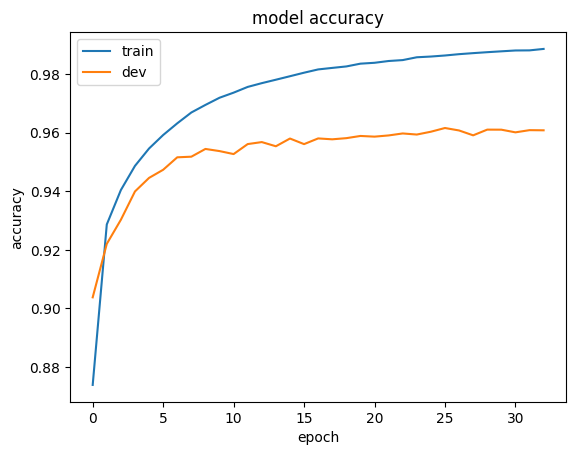

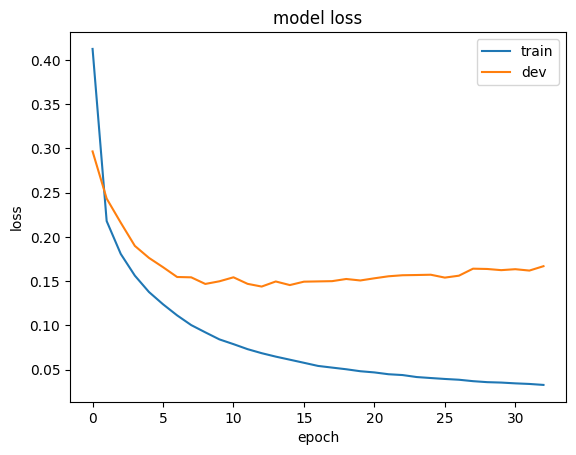

In [ ]:
# Plot model accuracy with respect to epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# Plot model loss with respect to epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

**Model Evaluation**

In [ ]:
# Evaluate the model on train, test, and dev sets
train_eval = evaluate_model(X_train_padded, y_train, model,"Train Set")
print('\n\n')
test_eval = evaluate_model(X_test_padded, y_test, model,"Test Set")
print('\n\n')
dev_eval = evaluate_model(X_dev_padded, y_dev, model,"Dev Set")

255/255 [==============================] - 2s 7ms/step
-----------Predection Scores for Train Set-----------
              precision    recall  f1-score   support

        NOUN       0.99      1.00      0.99     43208
         ADP       1.00      1.00      1.00     33872
         DET       1.00      1.00      1.00     33537
       PUNCT       1.00      1.00      1.00     24499
        VERB       0.99      0.99      0.99     16432
         ADJ       0.99      0.99      0.99     15250
       PROPN       0.99      0.96      0.98      9824
         ADV       1.00      1.00      1.00      8469
         AUX       1.00      1.00      1.00      7261
        PRON       0.99      1.00      0.99      7226
       CCONJ       1.00      1.00      1.00      6279
         NUM       0.99      0.99      0.99      5006
       SCONJ       0.99      0.97      0.98      1642
           X       1.00      0.93      0.96       266
        INTJ       0.98      0.92      0.95        59

    accuracy             